# StyleGAN - Inspect Trained Model

In [1]:
import os, time
import libs.configs.config
from time import gmtime, strftime
import numpy as np
import scipy.misc as sm
import matplotlib.pyplot as plt
import datasets.datapipe as datapipe
import libs.network.P2SNet as model
import tensorflow as tf
import tensorflow.contrib.slim as slim




# Configurations

In [2]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/device:CPU:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

MODEL_DIR = 'output/training'
base_dir = os.path.join('datasets', 'photo2style')

def saveimg(img):
    invert_img = (img + 1.) /2
    return invert_img


# Load Test Images

In [3]:
base_dir = os.path.join('datasets', 'photo2style')
test_A_files = os.listdir(os.path.join(base_dir, 'testA'))
test_B_files = os.listdir(os.path.join(base_dir, 'testB'))
np.random.shuffle(test_A_files)
np.random.shuffle(test_B_files)
print(len(test_A_files), len(test_B_files), test_A_files[0], test_B_files[0])
dataA = sm.imread(base_dir+'/testA/'+test_A_files[0])
dataB = sm.imread(base_dir+'/testB/'+test_B_files[0])



(25, 30, '2014-08-05 20:38:59.jpg', '000001.jpg')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


# Load Model

In [4]:
# Create model in inference mode
with tf.device(DEVICE):
    inputA = tf.placeholder(tf.float32, shape=[None, None, 3], name='inputA')
    inputB = tf.placeholder(tf.float32,shape=[None, None, 3], name='inputB')

    imageA = datapipe._preprocess_for_test(inputA)
    imageB = datapipe._preprocess_for_test(inputB)

    """ build network """
    net = model.P2SNet()
    net.inference(imageA, imageB)

Tensor("ExpandDims:0", shape=(1, 256, 256, 3), dtype=float32, device=/device:CPU:0)
Tensor("ExpandDims_1:0", shape=(1, 256, 256, 3), dtype=float32, device=/device:CPU:0)


# Run Detection

INFO:tensorflow:Restoring parameters from output/training/Style_GAN(p2s).ckpt-312000
('ckpt_path', u'output/training/Style_GAN(p2s).ckpt-312000')
INFO:tensorflow:Restoring parameters from output/training/Style_GAN(p2s).ckpt-312000


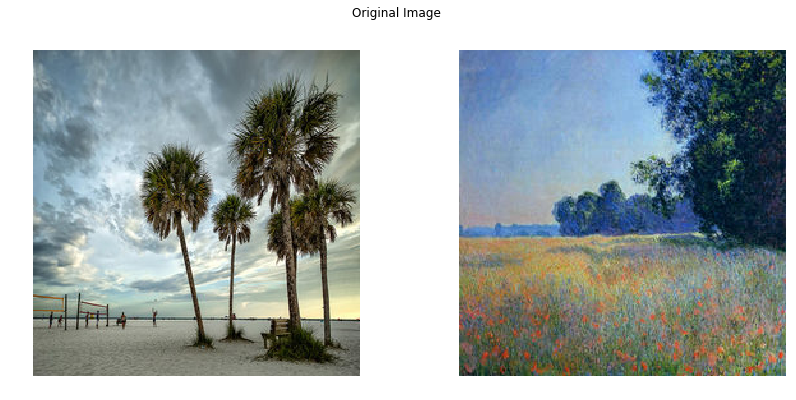

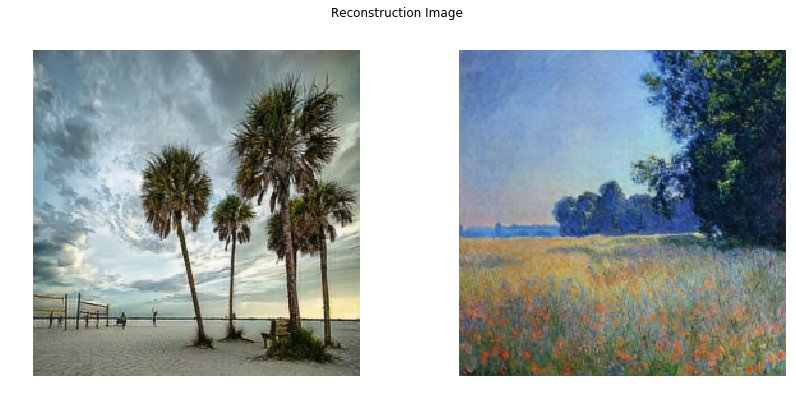

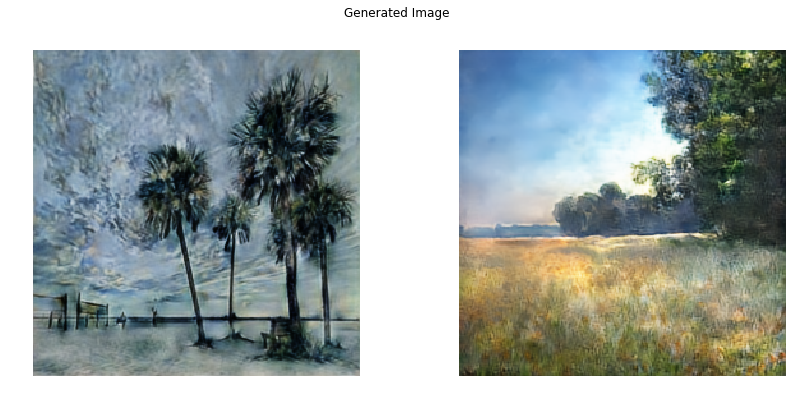

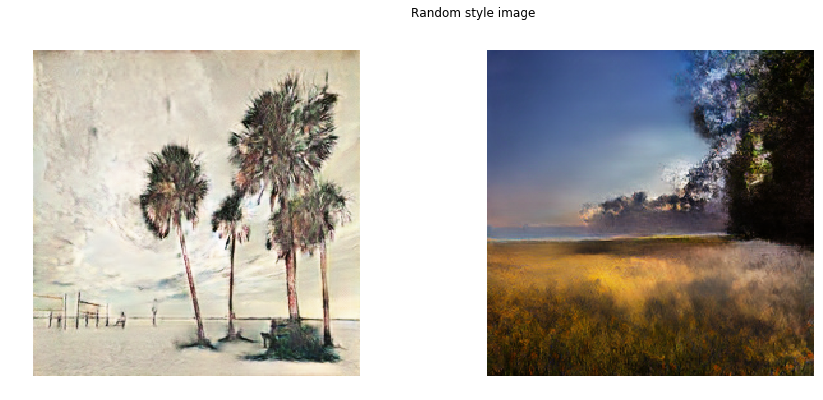

In [5]:
saver = tf.train.Saver()
init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
with tf.device(DEVICE):
    with tf.Session() as sess:
        sess.run(init_op)
        ckpt = tf.train.get_checkpoint_state(MODEL_DIR)
        """ resotre checkpoint of Backbone network """
        if ckpt is not None:
            ckpt_path = tf.train.latest_checkpoint(MODEL_DIR)
            saver.restore(sess, ckpt_path)
        else:
            ckpt_path = FLAGS.checkpoint_model
            saver.restore(sess, './output/models/Style_GAN_final(p2s).ckpt')
        print('ckpt_path', ckpt_path)
        
        saver.restore(sess, ckpt_path)
        
        
        feed_dict={inputA : dataA, inputB : dataB}
        recon_A, recon_B, fake_BA, fake_AB, rand_BA, rand_AB, = sess.run([net.recon_xa, net.recon_xb,
                                                                         net.fake_ba, net.fake_ab,
                                                                         net.rand_ba, net.rand_ab,], feed_dict=feed_dict)

        original_A = dataA
        original_B = dataB
        reconImg_A = saveimg(recon_A[0])
        reconImg_B = saveimg(recon_B[0])
        gen_A = saveimg(fake_AB[0])
        gen_B = saveimg(fake_BA[0])
        rand_A = saveimg(rand_AB[0])
        rand_B = saveimg(rand_BA[0])
        sess.close()

    fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig1.suptitle('Original Image')
    axes1[0].imshow(original_A)
    axes1[0].set_axis_off()
    axes1[1].imshow(original_B)
    axes1[1].set_axis_off()
    
    fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig2.suptitle('Reconstruction Image')
    axes2[0].imshow(reconImg_A)
    axes2[0].set_axis_off()
    axes2[1].imshow(reconImg_B)
    axes2[1].set_axis_off()
    
    fig3, axes3 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig3.suptitle('Generated Image')
    axes3[0].imshow(gen_A)
    axes3[0].set_axis_off()
    axes3[1].imshow(gen_B)
    axes3[1].set_axis_off()
    
    fig4, axes4 = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig4.suptitle('Random style image')
    axes4[0].imshow(rand_A)
    axes4[0].set_axis_off()
    axes4[1].imshow(rand_B)
    axes4[1].set_axis_off()

    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()
